# NLP Case Study - Automatic Ticket Classification

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re
import nltk 
import spacy
import string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
import pickle

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay
from pprint import pprint

In [2]:
# to suppress the warnings
import warnings
warnings.filterwarnings("ignore")

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
f = r"C:\Users\hp\Downloads\complaints-2021-05-14_08_16.json"

# returns JSON object as  
# a dictionary 
with open(f, "r", encoding="utf-8") as file:
    data = json.load(file)
df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
#checking the shape of the dataframe

df.shape

(78313, 22)

#### The Dataset has 78313 customner complaints and 22 features

In [6]:
#print the column names

list(df.columns)

['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

In [7]:
#Assign new column names

df.columns = ["index", "type", "id", "score", "tags", "zip_code","complaint_id", "issue", "date_received",
       "state", "consumer_disputed", "product","company_response", "company", "submitted_via",
       "date_sent_to_company", "company_public_response","sub_product", "timely",
       "complaint_what_happened", "sub_issue","consumer_consent_provided"]

In [8]:
#Assign nan in place of blanks in the complaints column
df[df.loc[:, 'complaint_what_happened'] == ''] = np.nan

#Remove all rows where complaints column is nan
df.dropna(subset=["complaint_what_happened"], inplace=True)

In [9]:
# Counting number of rows with blank under complaints column

len(df[df["complaint_what_happened"] == ""])

0

In [10]:
#checking the shape of the dataset

df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [11]:
# Veiwing the first five rows of the complaints column
df["complaint_what_happened"].head()

1     Good morning my name is XXXX XXXX and I apprec...
2     I upgraded my XXXX XXXX card in XX/XX/2018 and...
10    Chase Card was reported on XX/XX/2019. However...
11    On XX/XX/2018, while trying to book a XXXX  XX...
14    my grand son give me check for {$1600.00} i de...
Name: complaint_what_happened, dtype: object

In [12]:
# Write your function here to clean the text and remove all the unnecessary elements.

def clean_text(t):
    t = t.lower()        # Coverts text to lowercase
    t = re.sub(r"\[.*?\]","", t)        # Removes text in square brackets
    t = re.sub(r"[%s]" % re.escape(string.punctuation), '', t)        # Removes punctuations from the text
    t = re.sub(r"\w*\d\w*", "", t)       #Removes words with numbers in them
    return t

In [13]:
# Making a new dataframe containing text-cleaned complaints using the above created function on the complaints column

df_clean = pd.DataFrame(df['complaint_what_happened'].apply(clean_text))

In [14]:
# Checking the cleaned dataframe

df_clean.head()

,complaint_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...


In [15]:
#Write your function to Lemmatize the texts
def create_lemmatized_version(input_text):
    lemmatized_words = []
    document = nlp(input_text)
    for word in document:
        lemmatized_words.append(word.lemma_)
    return " ".join(lemmatized_words)

In [16]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean['Complaint_Lemmatized'] = df_clean['complaint_what_happened'].apply(create_lemmatized_version)

In [17]:
# Checking the cleaned dataframe
df_clean.head()

,complaint_what_happened,Complaint_Lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


In [19]:
#Write your function to extract the POS tags
def pos_tag(text):
  # write your code here
    nouns = []
    blob = TextBlob(text)
    nouns = [word for (word, tag) in blob.tags if tag == 'NN']
    return " ".join(nouns)


df_clean["Complaint_POS_Removed"] = df_clean["Complaint_Lemmatized"].apply(pos_tag)

In [21]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,Complaint_Lemmatized,Complaint_POS_Removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




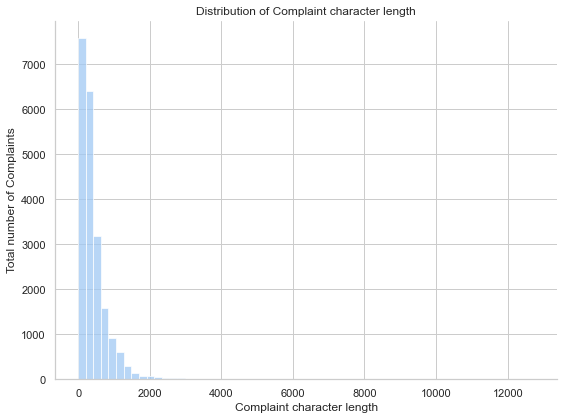

In [22]:
# Write your code here to visualise the data according to the 'Complaint' character length
char_len = [len(each_sent) for each_sent in df_clean['Complaint_POS_Removed']]

sns.set(style='whitegrid', palette="pastel")

plt.figure(figsize=(8, 6))

sns.histplot(char_len, bins=60, kde=False)
plt.xlabel("Complaint character length")
plt.ylabel("Total number of Complaints")
plt.title("Distribution of Complaint character length")

sns.despine()
plt.tight_layout()

plt.show()

### Observation
#### It seems to be skewed to the right but it is a normal distribution

#### Find the top 40 words by frequency among all the articles after processing the text.

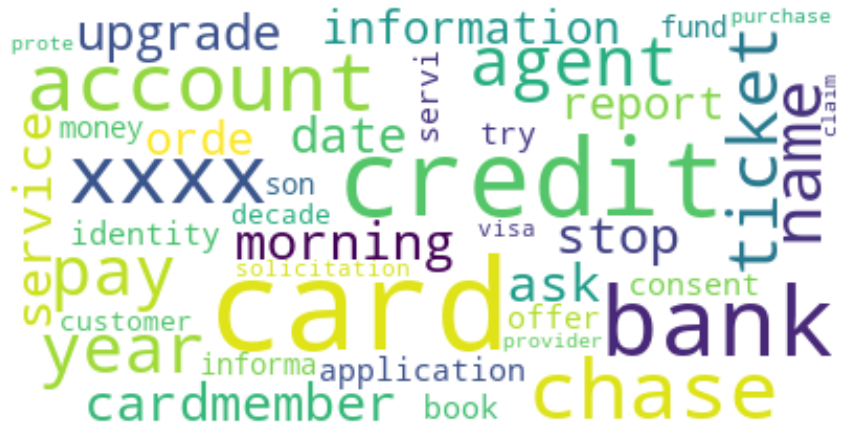

In [23]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=40, 
                      background_color="white", random_state=100, 
                      stopwords=stopwords).generate(str(df_clean["Complaint_POS_Removed"]))
plt.figure(figsize=[15,15])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [24]:
#Removing -PRON- from the text corpus
def remove_pron(substring):
    return substring.replace("-PRON-", "")

df_clean["Complaint_Clean"] = df_clean["Complaint_POS_Removed"].apply(remove_pron)

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [25]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

# Defining a function to get the top n words(unigrams)

def get_top_ngrams(text, n= None, ngram=(1,1)):
    vec = CountVectorizer(stop_words="english", ngram_range=ngram).fit(text)
    bagofwords = vec.transform(text)
    sum_words = bagofwords.sum(axis=0)
    word_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
    word_frequency = sorted(word_frequency, key = lambda x: x[1], reverse=True)
    return word_frequency[:n]

In [26]:
# Checking the top 30 words in the ingram frequency

top_30words = get_top_ngrams(df_clean['Complaint_Clean'].values.astype('U'), n=30, ngram=(1,1))
df_unigram = pd.DataFrame(top_30words, columns=['unigram', 'count'])
df_unigram

,unigram,count
0,account,47516
1,chase,46699
2,xxxx,36564
3,credit,34148
4,card,29278
5,bank,28403
6,payment,21166
7,time,16021
8,charge,14997
9,day,12972


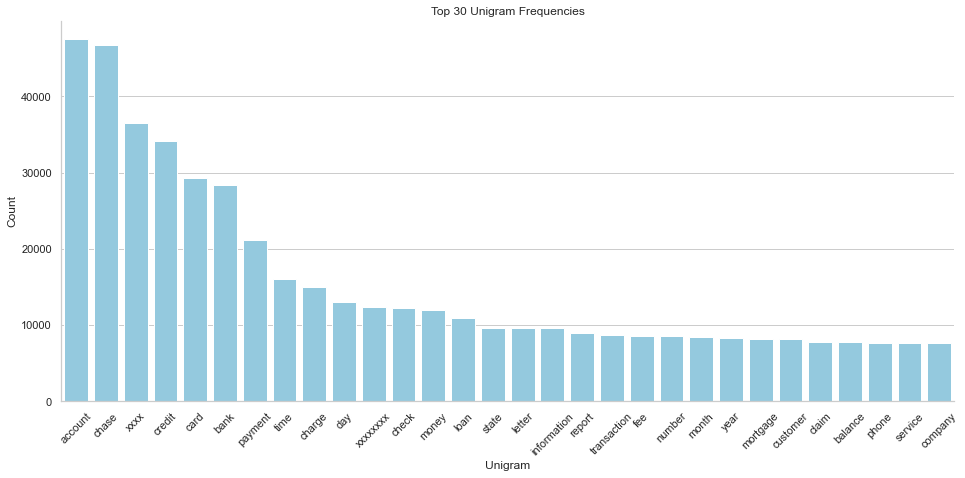

In [27]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
plt.figure(figsize=(16, 7))
sns.barplot(x=df_unigram["unigram"], y=df_unigram["count"], color="skyblue")
plt.xticks(rotation=45)
plt.xlabel("Unigram")
plt.ylabel("Count")
plt.title("Top 30 Unigram Frequencies")
sns.despine()
plt.show()

In [28]:
#Print the top 10 words in the unigram frequency
df_unigram.head(10)

,unigram,count
0,account,47516
1,chase,46699
2,xxxx,36564
3,credit,34148
4,card,29278
5,bank,28403
6,payment,21166
7,time,16021
8,charge,14997
9,day,12972


In [29]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_words = get_top_ngrams(df_clean["Complaint_Clean"].values.astype("U"), n=30, ngram=(2,2))
df_bigram = pd.DataFrame(top_30_words, columns=["bigram", "count"])
df_bigram

,bigram,count
0,credit card,12778
1,credit report,3955
2,xxxx xxxx,3951
3,customer service,3081
4,chase credit,2966
5,chase bank,2941
6,bank account,2729
7,account chase,2595
8,chase account,2564
9,check account,2413


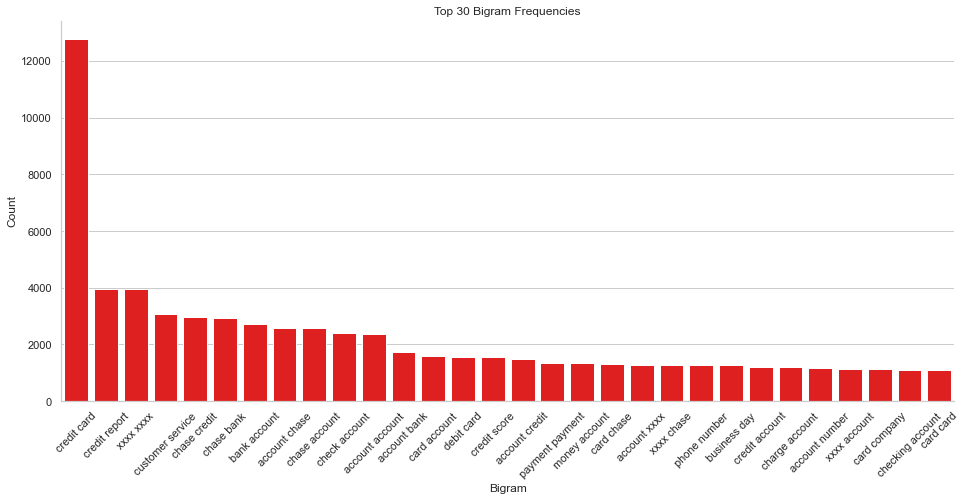

In [30]:
#Top 30 bigram frequencies among the cleaned dataframe
plt.figure(figsize=(16, 7))
sns.barplot(x=df_bigram["bigram"], y=df_bigram["count"], color="red")
plt.xticks(rotation=45)
plt.xlabel("Bigram")
plt.ylabel("Count")
plt.title("Top 30 Bigram Frequencies")
sns.despine()
plt.show()

In [31]:
#Print the top 10 words in the bigram frequency
df_bigram.head(10)

,bigram,count
0,credit card,12778
1,credit report,3955
2,xxxx xxxx,3951
3,customer service,3081
4,chase credit,2966
5,chase bank,2941
6,bank account,2729
7,account chase,2595
8,chase account,2564
9,check account,2413


In [32]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_words = get_top_ngrams(df_clean["Complaint_Clean"].values.astype("U"), n=30, ngram=(3,3))
df_trigram = pd.DataFrame(top_30_words, columns=["trigram", "count"])
df_trigram

,trigram,count
0,chase credit card,2063
1,credit card account,1022
2,credit card company,991
3,credit card chase,632
4,credit card credit,515
5,inquiry credit report,481
6,charge credit card,421
7,xxxx xxxx xxxx,411
8,account credit card,398
9,card credit card,388


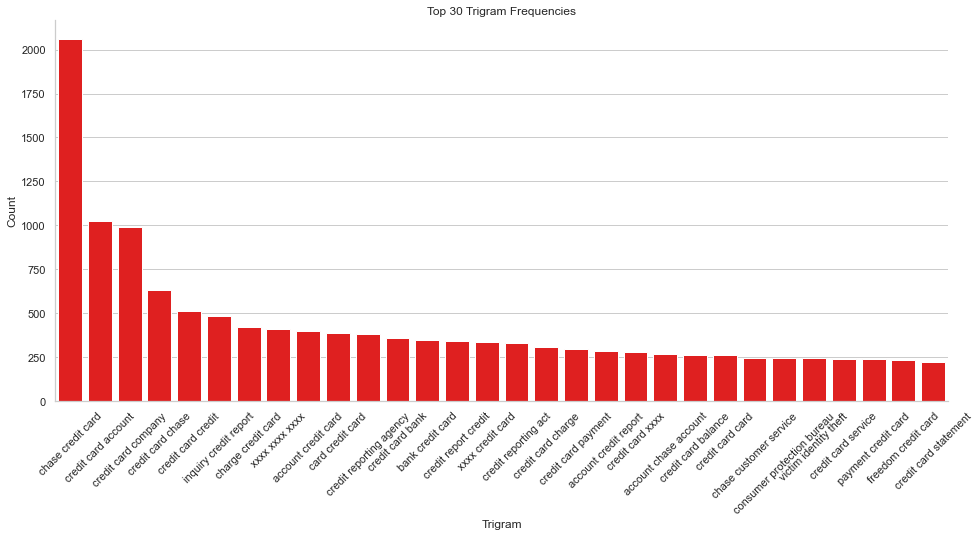

In [33]:
#Top 30 bigram frequencies among the cleaned dataframe
plt.figure(figsize=(16, 7))
sns.barplot(x=df_trigram["trigram"], y=df_trigram["count"], color="red")
plt.xticks(rotation=45)
plt.xlabel("Trigram")
plt.ylabel("Count")
plt.title("Top 30 Trigram Frequencies")
sns.despine()
plt.show()

In [34]:
#Print the top 10 words in the trigram frequency
df_trigram.head(10)

,trigram,count
0,chase credit card,2063
1,credit card account,1022
2,credit card company,991
3,credit card chase,632
4,credit card credit,515
5,inquiry credit report,481
6,charge credit card,421
7,xxxx xxxx xxxx,411
8,account credit card,398
9,card credit card,388


#### The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [35]:
df_clean['Complaint_Clean'] = df_clean['Complaint_Clean'].str.replace('xxxx','')

In [36]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,Complaint_Lemmatized,Complaint_POS_Removed,Complaint_Clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...


In [37]:
df_clean.shape

(21072, 4)

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [38]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words="english")

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [40]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean["Complaint_Clean"])

In [41]:
dtm

<21072x7263 sparse matrix of type '<class 'numpy.float64'>'
	with 643552 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [42]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [43]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [44]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

7263

In [45]:
ttm = nmf_model.components_

In [46]:
#Print the Top15 words for each of the topics

words = np.array(tfidf.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f"Topic {i + 1}" for i in range(num_topics)],
                           columns=[f"Word {i + 1}" for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = ttm[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,chase,deposit,branch,day,number,business,transaction,claim,transfer,customer
Topic 2,credit,card,report,inquiry,chase,account,score,company,limit,information,debt,application,letter,year,balance
Topic 3,payment,balance,month,fee,statement,day,time,auto,date,pay,credit,account,chase,year,mortgage
Topic 4,charge,card,fee,transaction,dispute,chase,merchant,fraud,claim,purchase,service,time,statement,refund,company
Topic 5,loan,mortgage,home,modification,chase,property,year,letter,rate,time,document,bank,house,foreclosure,sale


In [47]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)

In [48]:
#Assign the best topic to each of the complaints in Topic Column
df_clean["Topic"] = topic_results.argmax(axis=1)

In [49]:
# Checking the df_clean dataframe
df_clean.head()

,complaint_what_happened,Complaint_Lemmatized,Complaint_POS_Removed,Complaint_Clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [50]:
#Print the first 5 Complaint for each of the Topics
df_clean_top5=df_clean.groupby("Topic").head(5)
df_clean_top5.sort_values("Topic")

,complaint_what_happened,Complaint_Lemmatized,Complaint_POS_Removed,Complaint_Clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [51]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Others",
               3:"Theft/Dispute reporting", 4:"Mortgages/loans"}
#Replace Topics with Topic Names
df_clean["Topic"] = df_clean["Topic"].map(Topic_names)

In [52]:
# Checking the Shape
df_clean.shape

(21072, 5)

In [53]:
# Checking the df_clean dataframe
df_clean.head()

,complaint_what_happened,Complaint_Lemmatized,Complaint_POS_Removed,Complaint_Clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Bank account services
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Credit card / Prepaid card
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,Credit card / Prepaid card
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit card / Prepaid card
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank account services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [54]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank account services":0, "Credit card / Prepaid card":1, "Others":2,
               "Theft/Dispute reporting":3, "Mortgages/loans":4}
#Replace Topics with Topic Names
df_clean["Topic"] = df_clean["Topic"].map(Topic_names)

In [55]:
# Checking the Shape
df_clean.shape

(21072, 5)

In [56]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[["complaint_what_happened", "Topic"]]

In [57]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in and was told ...,1
10,chase card was reported on however fraudulent...,1
11,on while trying to book a xxxx xxxx ticket ...,1
14,my grand son give me check for i deposit it i...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,3
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs ive had ch...,2


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [58]:
#Write your code to get the Vector count
vect = CountVectorizer()
X_train_cnt = vect.fit_transform(training_data["complaint_what_happened"])

#Saving the word Vector
pickle.dump(vect.vocabulary_, open("count_vector.pk1", "wb"))


In [59]:
#Write your code here to transform the word vector to tf-idf

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)

# Save tfidf
pickle.dump(tfidf_transformer, open("tfidf.pk1", "wb"))

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

## Logistic Regression

In [60]:
# Splitting the dataset into train and test dataset

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data["Topic"], test_size=0.25, random_state=42)

In [61]:
lr = LogisticRegression(random_state = 42, solver="liblinear").fit(X_train, y_train)

In [62]:
# Getting the score of the base model

lr.score(X_test, y_test)

0.9164768413059985

The accuracy with the base model is 91.64%

### HyperParameter Tuning

In [63]:
lr_grid = {"C": [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],
                "solver": ["liblinear"]}

In [64]:
# Setup grid hyperparameter search for LogisticRegression
lr_hpt = GridSearchCV(LogisticRegression(random_state=42),
                                param_grid=lr_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
lr_hpt.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],
                         'solver': ['liblinear']},
             verbose=True)

In [65]:
# Checking best parameters

lr_hpt.best_params_

{'C': 4, 'solver': 'liblinear'}

In [66]:
# Evaluating the tuned model

lr_hpt.score(X_test, y_test)

0.9198936977980258

The accuracy of the tuned Logistic Regression Model turned out to be 92.10% which is an improvement over the base model's accuracy of 91.57%

In [67]:
# Saving Logistic Regression Model
pickle.dump(lr_hpt, open("lr_model.pk1", "wb"))

### Model Evaluation

In [68]:
# Load pickled model

lr_model = pickle.load(open("lr_model.pk1", "rb"))

In [69]:
# Making predictions on test data

y_pred = lr_model.predict(X_test)

In [70]:
# Printing Confusion Matrix

print(confusion_matrix(y_test, y_pred))

[[1239   21    8   35   15]
 [  22 1195    8   42    8]
 [  10   17  497   13   19]
 [  65   45    5 1071   20]
 [  22   23   11   13  844]]


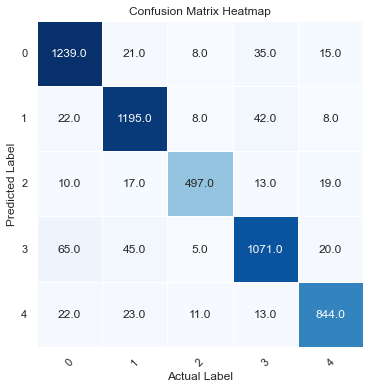

In [73]:
# Visualizing Confusion Matrix with heatmap

confusion_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cbar=False, cmap="Blues", fmt=".1f", linewidths=0.5, square=True)
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")
plt.title("Confusion Matrix Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [74]:
# Creating the target list
target = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]

In [75]:
# Printing Classification Report
print(classification_report(y_test, y_pred, target_names = target))

                            precision    recall  f1-score   support

     Bank account services       0.91      0.94      0.93      1318
Credit card / Prepaid card       0.92      0.94      0.93      1275
                    Others       0.94      0.89      0.92       556
   Theft/Dispute reporting       0.91      0.89      0.90      1206
           Mortgages/loans       0.93      0.92      0.93       913

                  accuracy                           0.92      5268
                 macro avg       0.92      0.92      0.92      5268
              weighted avg       0.92      0.92      0.92      5268



1. Overall accuracy:- 92%. 
2. Precision:- 92%
3. Recall:- 92%

Therefore we can consider this as a Decent Model

## Decision Tree Classifier

In [76]:
# Splitting the dataset into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data["Topic"], test_size=0.25, random_state=42)

In [77]:
#Fitting on train data
dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [78]:
# Getting the score of the base model
dt.score(X_test, y_test)

0.7820804859529233

A base Decision Tree gives an accuracy of approximately 78.21%

### HyperParameter Tuning

In [79]:
dt_grid = {"max_depth": [3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [80]:
# Setup grid hyperparameter search for Decision Tree Classifier
dt_hpt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                                param_grid=dt_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
dt_hpt.fit(X_train, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10],
                         'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])},
             verbose=True)

In [81]:
# Checking best parameters
dt_hpt.best_params_

{'max_depth': 10, 'min_samples_leaf': 13, 'min_samples_split': 2}

In [82]:
# Evaluating the tuned model
dt_hpt.score(X_test, y_test)

0.7731586940015186

1. Tuned Decision Tree Accuracy = 77.31%
2. Base Decision Tree Accuracy = 78.21%
The tuned decision tree accuracy is lesser than than the base decision tree accuracy

In [83]:
# Saving Decision Tree Model
pickle.dump(dt_hpt, open("dt_model.pk1", "wb"))

### Model Evaluation

In [84]:
# Load pickled model
dt_model = pickle.load(open("dt_model.pk1", "rb"))

In [85]:
# Making predictions on test data
y_pred = dt_model.predict(X_test)

In [86]:
# Printing Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1054   66   29   65  104]
 [  47 1048   25   80   75]
 [  35   38  430   16   37]
 [ 152  132   24  746  152]
 [  45   24   27   22  795]]


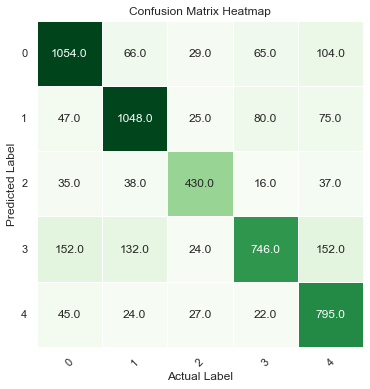

In [88]:
# Visualizing Confusion Matrix with heatmap

confusion_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cbar=False, cmap="Greens", fmt=".1f", linewidths=0.5, square=True)
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")
plt.title("Confusion Matrix Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [89]:
# target data
target = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]

In [90]:
# Printing the Classification Report
print(classification_report(y_test, y_pred, target_names = target))

                            precision    recall  f1-score   support

     Bank account services       0.79      0.80      0.80      1318
Credit card / Prepaid card       0.80      0.82      0.81      1275
                    Others       0.80      0.77      0.79       556
   Theft/Dispute reporting       0.80      0.62      0.70      1206
           Mortgages/loans       0.68      0.87      0.77       913

                  accuracy                           0.77      5268
                 macro avg       0.78      0.78      0.77      5268
              weighted avg       0.78      0.77      0.77      5268



1. Overall accuracy:- 77%. 
2. Precision:- 78%
3. Recall:- 77%

The overall accuracy of this mode at 77% is very poor compared to the Logistic Regression model, which has an accuracy of 92%.

## Random Forest Classifier

In [91]:
# Splitting Train and Test datasets
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data["Topic"], test_size=0.25, random_state=42)

In [92]:
# Fitting to train data
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [93]:
# Getting the score of the base model
rf.score(X_test, y_test)

0.8132118451025057

The Base Random Forest model has an accuracy of 81.32%

### HyperParameter Tuning 

In [94]:
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [95]:
# Setup random hyperparameter search for Random Forest
rf_hpt = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                param_distributions=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
rf_hpt.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [96]:
# Checking best parameters
rf_hpt.best_params_

{'n_estimators': 760,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_depth': 10}

In [97]:
# Evaluating the tuned model
rf_hpt.score(X_test, y_test)

0.7298785117691724

Randomized Search led to an accuracy of 72.98% in the tuned Decision Tree model. This can be further tuned to get a better accuracy.

In [98]:
rf_grid = {"n_estimators": [200, 260, 300],
           "max_depth": [7, 10, 15],
           "min_samples_split": [10, 12, 14],
           "min_samples_leaf": [6, 8, 10]}

In [99]:
# Setup grid hyperparameter search for Random Forest Classifier
rf_hpt = GridSearchCV(RandomForestClassifier(random_state=42),
                                param_grid=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
rf_hpt.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [7, 10, 15],
                         'min_samples_leaf': [6, 8, 10],
                         'min_samples_split': [10, 12, 14],
                         'n_estimators': [200, 260, 300]},
             verbose=True)

In [100]:
# Checking best parameters
rf_hpt.best_params_

{'max_depth': 15,
 'min_samples_leaf': 6,
 'min_samples_split': 14,
 'n_estimators': 260}

In [101]:
# Evaluating the tuned model
rf_hpt.score(X_test, y_test)

0.753037205770691

After Grid Search, the Model gave an accuracy of 75.30%

In [102]:
# Save Random Forest Model
pickle.dump(rf_hpt, open("rf_model.pk1", "wb"))

### Model Evaluation

In [103]:
# Load pickled model
rf_model = pickle.load(open("rf_model.pk1", "rb"))

In [104]:
# Make predictions on test data
y_pred = rf_model.predict(X_test)

In [105]:
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1205   81    0   24    8]
 [  65 1098    0  102   10]
 [ 136  182   39   85  114]
 [ 175  131    1  890    9]
 [  64  101    0   13  735]]


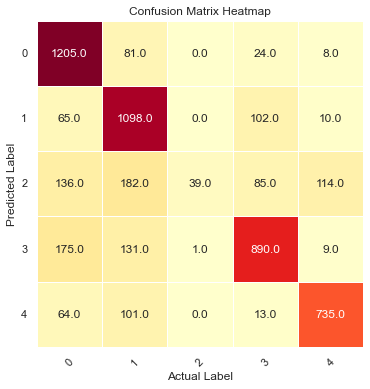

In [108]:
# Visualize Confusion Matrix with heatmap
confusion_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cbar=False, cmap="YlOrRd", fmt=".1f", linewidths=0.5, square=True)
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")
plt.title("Confusion Matrix Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [109]:
# Target List
target = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]

In [110]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = target))

                            precision    recall  f1-score   support

     Bank account services       0.73      0.91      0.81      1318
Credit card / Prepaid card       0.69      0.86      0.77      1275
                    Others       0.97      0.07      0.13       556
   Theft/Dispute reporting       0.80      0.74      0.77      1206
           Mortgages/loans       0.84      0.81      0.82       913

                  accuracy                           0.75      5268
                 macro avg       0.81      0.68      0.66      5268
              weighted avg       0.78      0.75      0.72      5268



1. Overall accuracy:- 75% 
2. Precision:- 78%
3. Recall:- 75%

The overall accuracy of this model at 75% is very poor compared to the Logistic Regression model, which has an accuracy of 92%. The model also overfits for 'Others' as the precision is 97%.

# Outcomes

Three supervised models were created:-

    1. Logistic Regression
    2. Decision Trees
    3. Random Forests

# Results

### Logistic Regression 

1. Overall accuracy:- 92%. 
2. Precision:- 92%
3. Recall:- 92%

### Decision Tree Classifier

1. Overall accuracy:- 77%
2. Precision:- 78%
3. Recall:- 77%

### Random Forest Classifier

1. Overall accuracy:- 75% 
2. Precision:- 78%
3. Recall:- 75%

# Conclusion

Logistic Regression, with an accuracy of 92%, with a Precision of 92% and a Recall of 92%, is the best when conpared to the other supervised models.